In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/new_ind_all_400", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]

In [16]:
shap_values

[array([[  7.31248777,   0.        ,   2.54812584, ..., -33.12887998,
           6.6685672 , -11.52143474],
        [ 93.85225443,   1.1273887 ,  -2.43769591, ..., -20.85345433,
           6.50250075,  50.4022842 ],
        [-32.34534556,  29.03846292,   0.        , ..., -27.39527058,
          -1.36066518, -30.49025481],
        ...,
        [  0.        ,  -1.82039745,   0.        , ...,  -5.22745349,
           0.32328944,  -2.1548223 ],
        [ 25.08016   ,  24.2826868 , -66.87194298, ..., -17.65018988,
         -35.27911578,  -6.34211451],
        [  5.53847153,   5.30692439,   2.97013556, ...,   1.24591032,
           0.        ,   0.        ]]),
 array([[  18.2747935 ,   11.5458003 ,    0.        , ...,  -89.98299936,
            9.62078993,  -21.52068086],
        [  13.04802339,    0.        ,  -23.30385219, ...,   22.65098243,
            0.        ,    0.        ],
        [   0.        ,   -1.2759101 ,  -10.40344073, ...,    6.18077144,
            0.        ,    0.      

In [17]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [18]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.964177,0.715558,0.716592,0.0,0.684122,0.0,0.136883,0.624877,0.0,0.877226


In [19]:
gmm_model_get_prediction_ae(patient)[0]

array([9.19121317e-23, 6.06741518e-04, 9.99393258e-01])

In [20]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [9.19121317e-23 6.06741518e-04 9.99393258e-01]
Predicted class: 2


#### Control

In [21]:
import shap

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [25]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

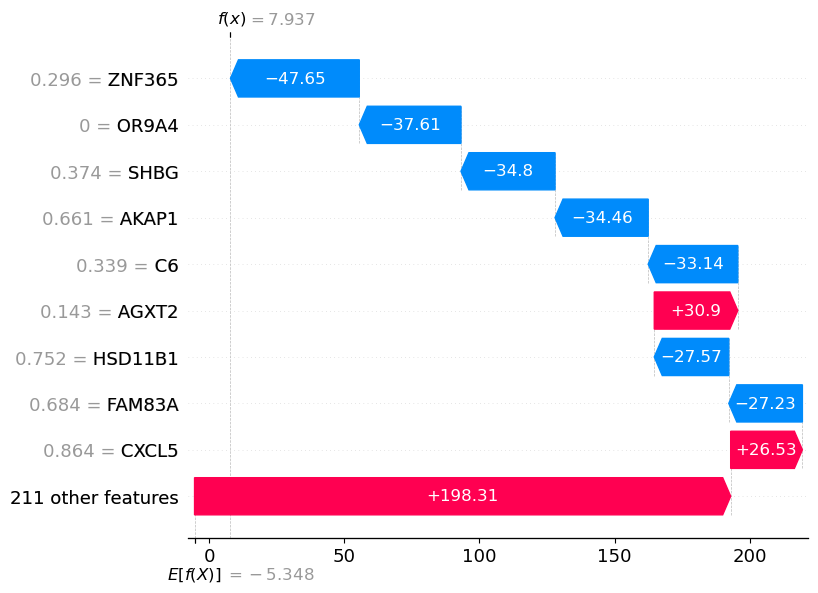

In [26]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [27]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

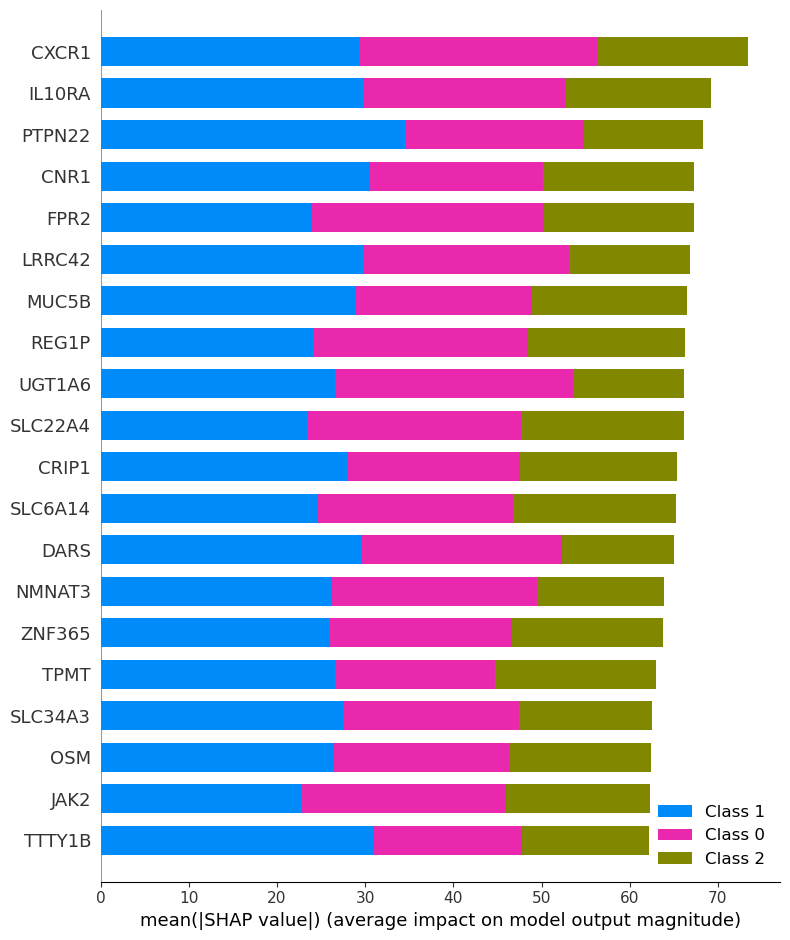

In [30]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


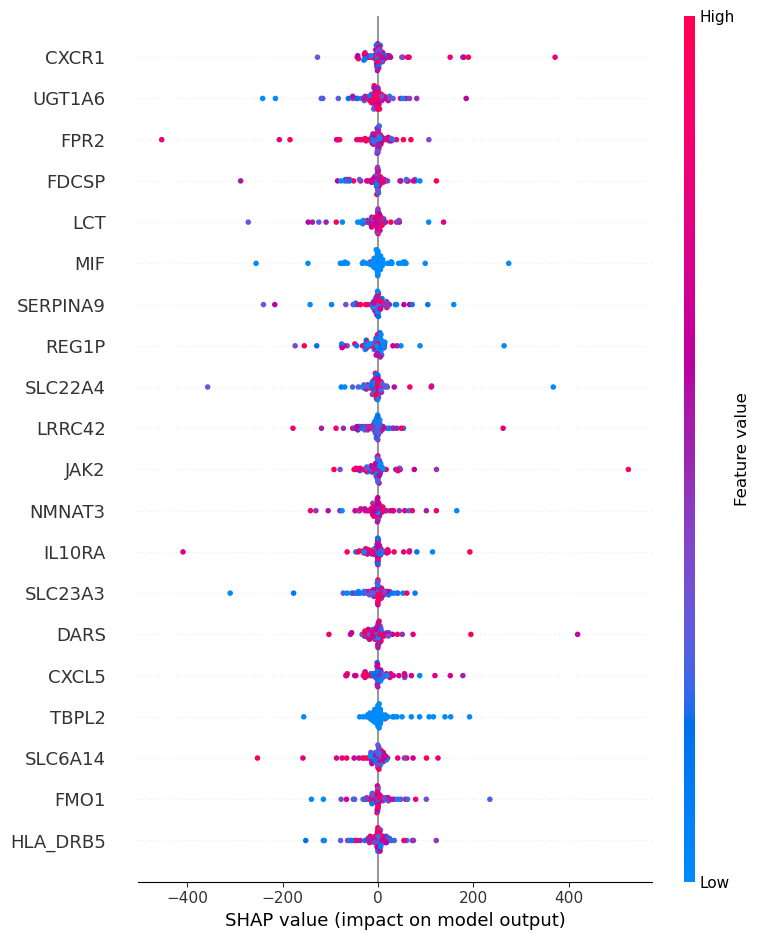

In [31]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

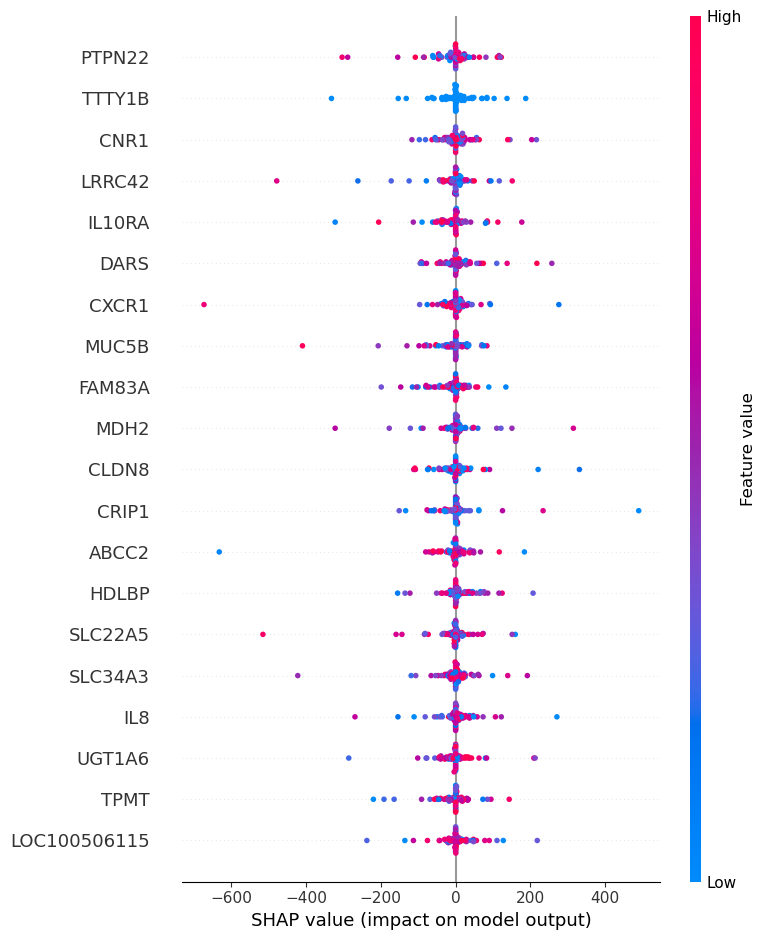

In [32]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

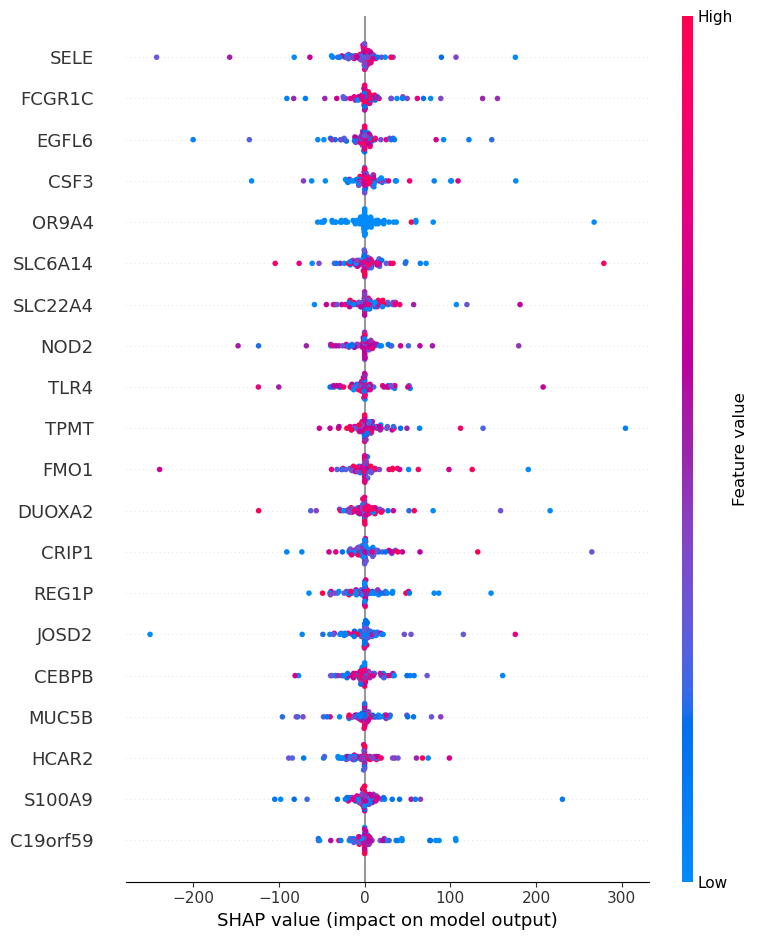

In [33]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

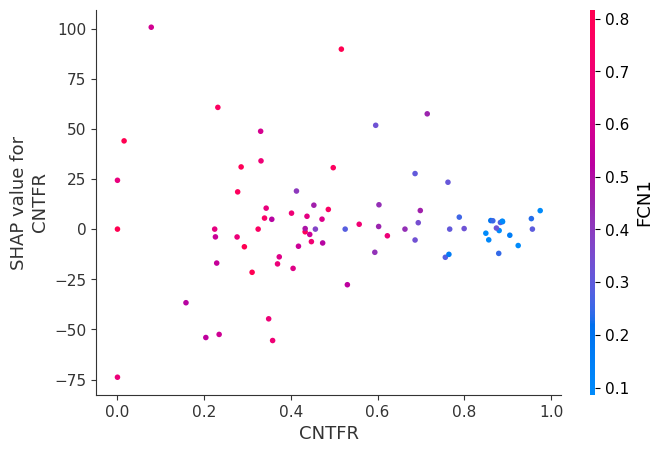

In [34]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

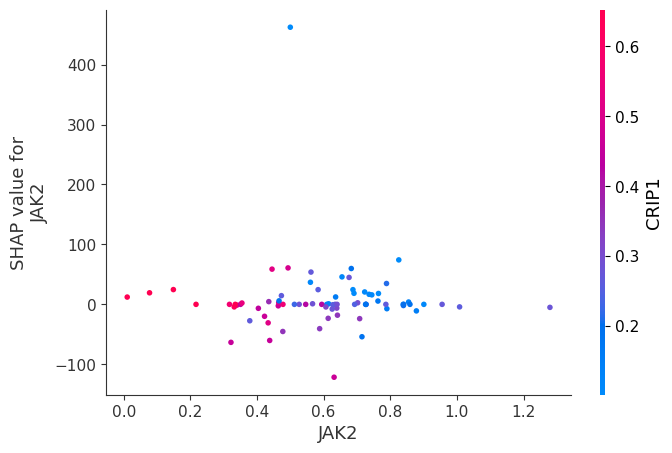

In [143]:
# CD no ulcer
shap.dependence_plot("JAK2", shap_values[1], x_test_scaled)

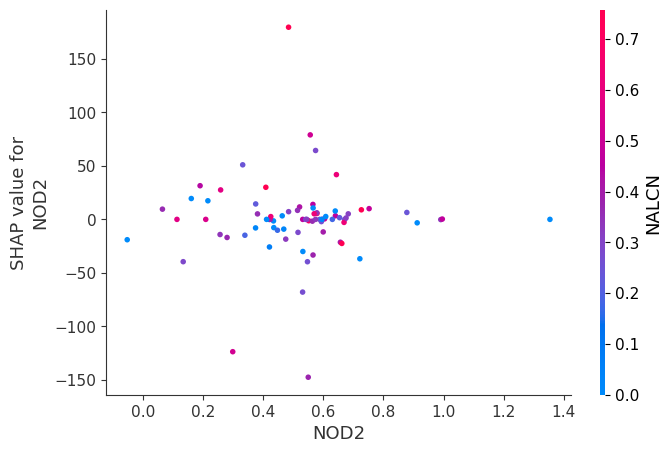

In [96]:
# CD deep ulcer
shap.dependence_plot("NOD2",shap_values[2], x_test_scaled)

## Clustering

In [37]:
disease_labels_test.shape

(78,)

In [38]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [39]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|██████████████████████████████████████████████████████████████▌                 | 172/220 [01:06<00:18,  2.59it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 216/220 [01:22<00:01,  3.42it/s]No/low signal found from feature 215 (this is typically cause

In [40]:
# clustering

In [41]:
# clustering.shape

In [42]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [43]:
type(exp)

shap._explanation.Explanation

In [44]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [45]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

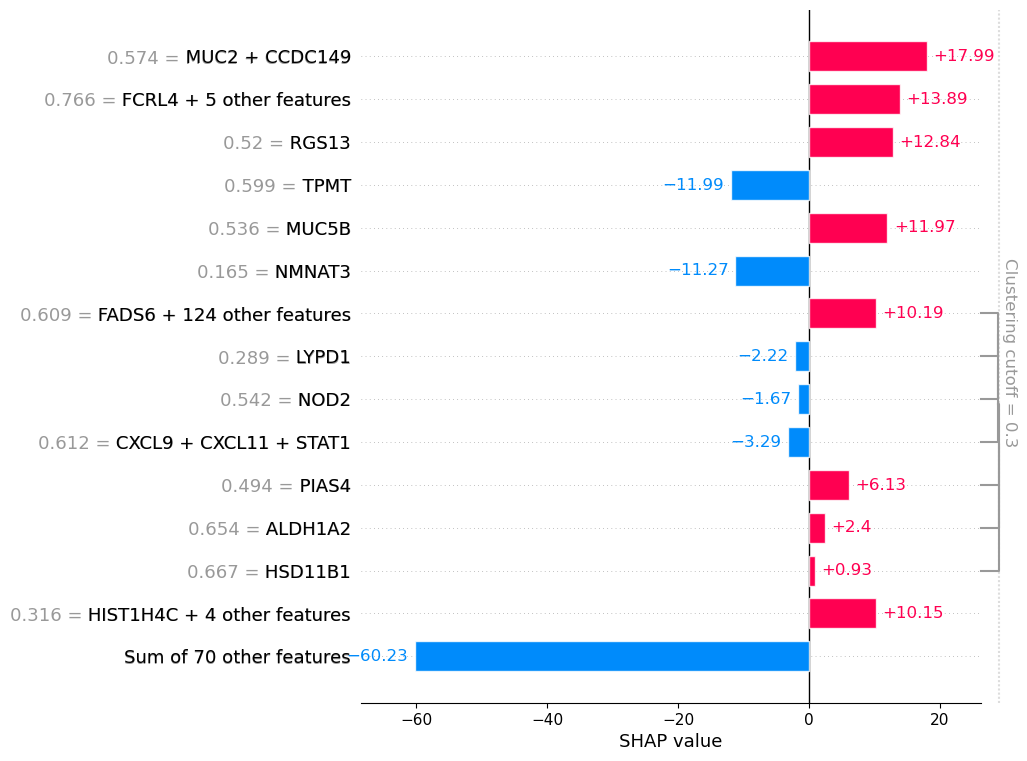

In [46]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [48]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,6.289116,0.866437,1.732786,-1.782827,2.927007,4.835665,5.372724,0.000000,1.586166,...,-0.070224,0.105868,-28.797143,-12.416988,-7.700027,-5.281684,9.747505,-2.854340,-6.433086,16.015109
167_CD_deep_ulcer,0.000000,0.000000,57.741192,-101.019448,1.905779,3.141861,89.489328,7.227366,-2.699353,-5.767842,...,8.729910,4.439151,8.982609,-5.730648,-13.026385,-5.449234,72.389340,-42.729326,-6.573610,96.835082
196_CD_deep_ulcer,6.798389,0.000000,5.148595,13.710970,0.000000,23.227178,-38.636531,0.926537,-6.273502,0.000000,...,5.295635,-0.164094,-1.134212,0.000000,-0.168707,-6.588686,-10.152624,14.733828,14.825840,-25.912554
23_CD_deep_ulcer,-8.735915,-21.613763,6.631448,6.530014,-8.209825,0.000000,5.435236,7.363332,8.124443,-4.124619,...,6.659306,-16.733443,-3.319930,-26.358982,7.139708,3.023525,18.216314,6.678358,-16.975749,7.693440
93_CD_deep_ulcer,0.084698,-2.527241,0.000000,0.000000,-4.448500,-2.676122,0.000000,-0.558659,-0.793957,0.000000,...,-2.442716,-1.631299,2.140351,0.000000,2.125572,-0.976030,-0.185610,0.000000,-0.148428,-2.104224
229_CD_deep_ulcer,-4.008600,11.668690,5.871349,4.123122,0.120787,0.000000,4.264924,-9.136541,-5.676615,-0.961760,...,-2.465595,-0.547167,3.979210,-2.497320,3.927998,-1.711398,-0.537262,-6.687596,-2.023016,1.074691
46_CD_deep_ulcer,5.444803,15.834914,-16.204357,7.113186,9.885216,-10.218768,-33.136742,6.127158,0.000000,3.331800,...,0.305978,0.000000,-5.560307,14.688948,-27.226780,-3.926573,-11.808253,0.978817,4.062491,0.248157
176_CD_deep_ulcer,0.000000,-2.383427,0.000000,1.344746,2.136824,-1.578207,0.124908,-0.726253,-4.874710,-0.205951,...,-1.186536,-2.413901,6.638033,-2.263485,-3.544202,1.103770,1.136670,-5.435169,3.629231,-1.639777
49_CD_deep_ulcer,-34.890732,15.795545,-18.859643,8.325296,42.587423,0.000000,0.000000,-7.075868,52.652770,-26.788123,...,151.140856,0.000000,-8.953749,42.876414,7.929053,30.051868,-49.988338,42.873870,0.000000,39.076661


### Example: CD deep ulcer patients

In [118]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

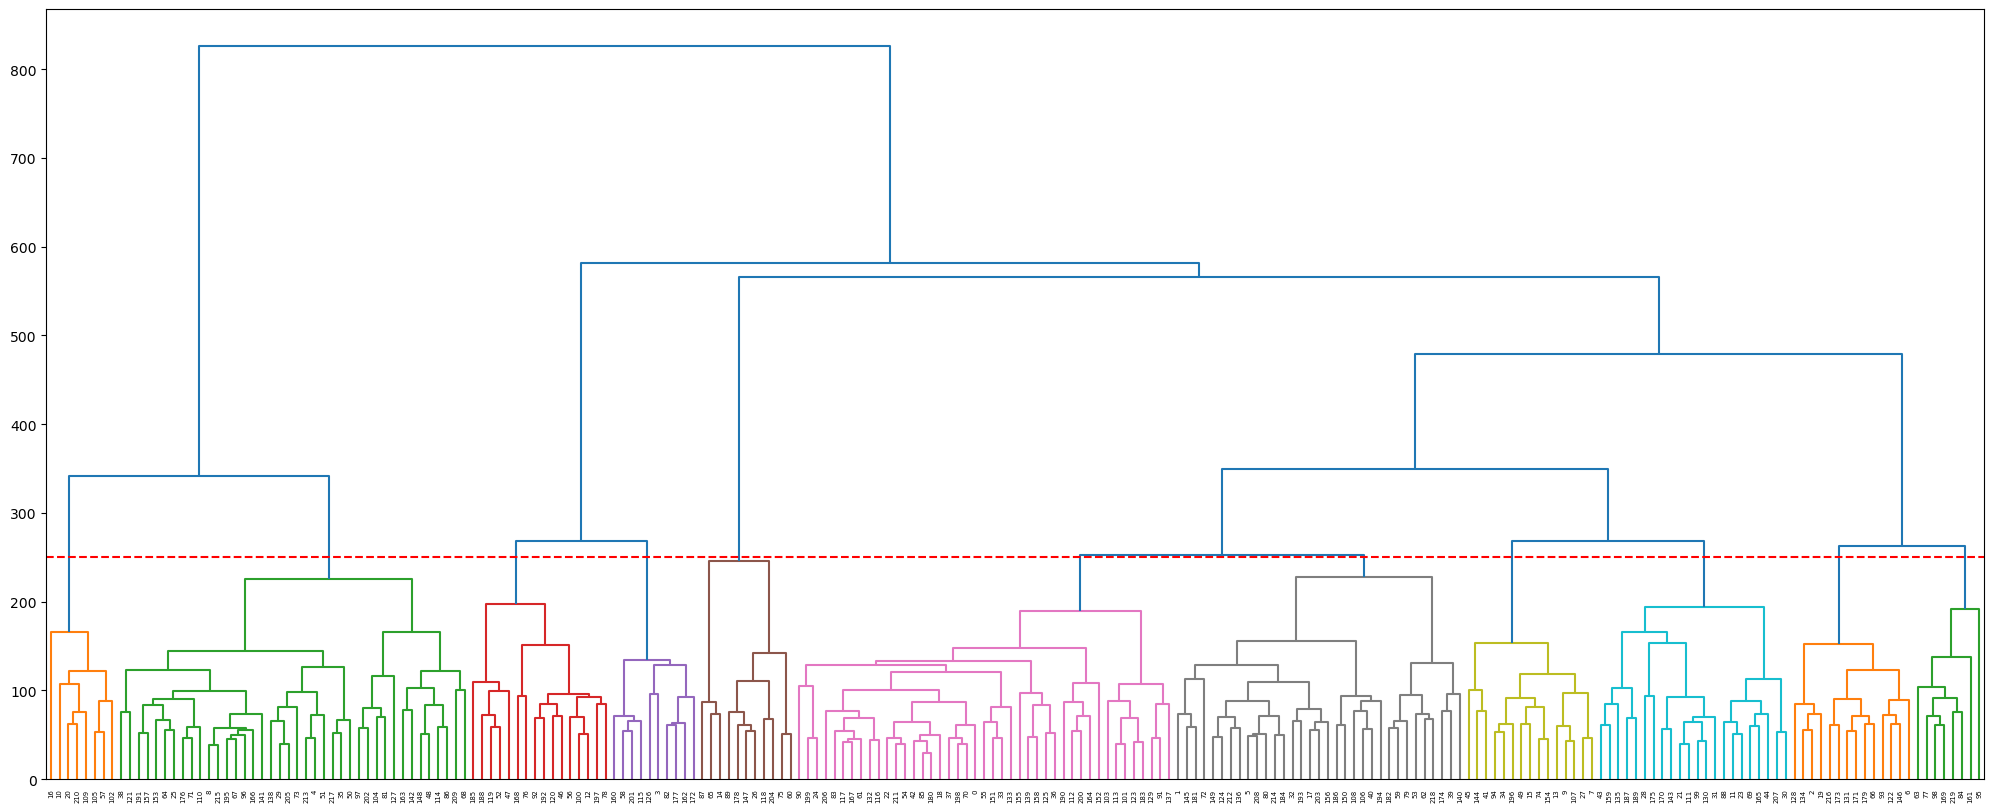

In [119]:
thresh=250
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [120]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 16,  10,  20, 210, 109, 105,  57, 102,  38, 121, 191, 157, 153,
        64,  25, 176,  71, 110,   8, 215, 195,  67,  96, 166, 141, 138,
        29, 205,  73, 213,   4,  51, 217,  35,  50,  97, 202, 104,  81,
       127, 163, 142, 148,  48, 114,  86, 209,  68, 185, 188, 119,  52,
        47, 168,  76,  92, 192, 120,  46,  56, 100,  12, 197,  78, 160,
        58, 201, 115, 126,   3,  82, 177, 162, 172,  87,  65,  14,  89,
       178, 147,  26, 118, 204,  75,  60,  90, 199,  24, 206,  83, 117,
       167,  61, 132, 116,  22, 211,  54,  42,  85, 180,  18,  37, 198,
        70,   0,  55, 151,  33, 133, 155, 139, 158, 125,  36, 190, 112,
       200, 164, 152, 103, 113, 101, 123, 183, 129,  91, 137,   1, 145,
       181,  72, 149, 124, 212, 136,   5, 208,  80, 214, 184,  32, 193,
        17, 203, 156, 186, 150, 108, 106,  40, 194, 182,  59,  79,  53,
        62, 218, 174,  39, 140,  45, 144,  41,  94,  34, 196,  49,  15,
        74, 154,  13,   9, 107,  27,   7,  43, 159, 135, 187, 18

In [121]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

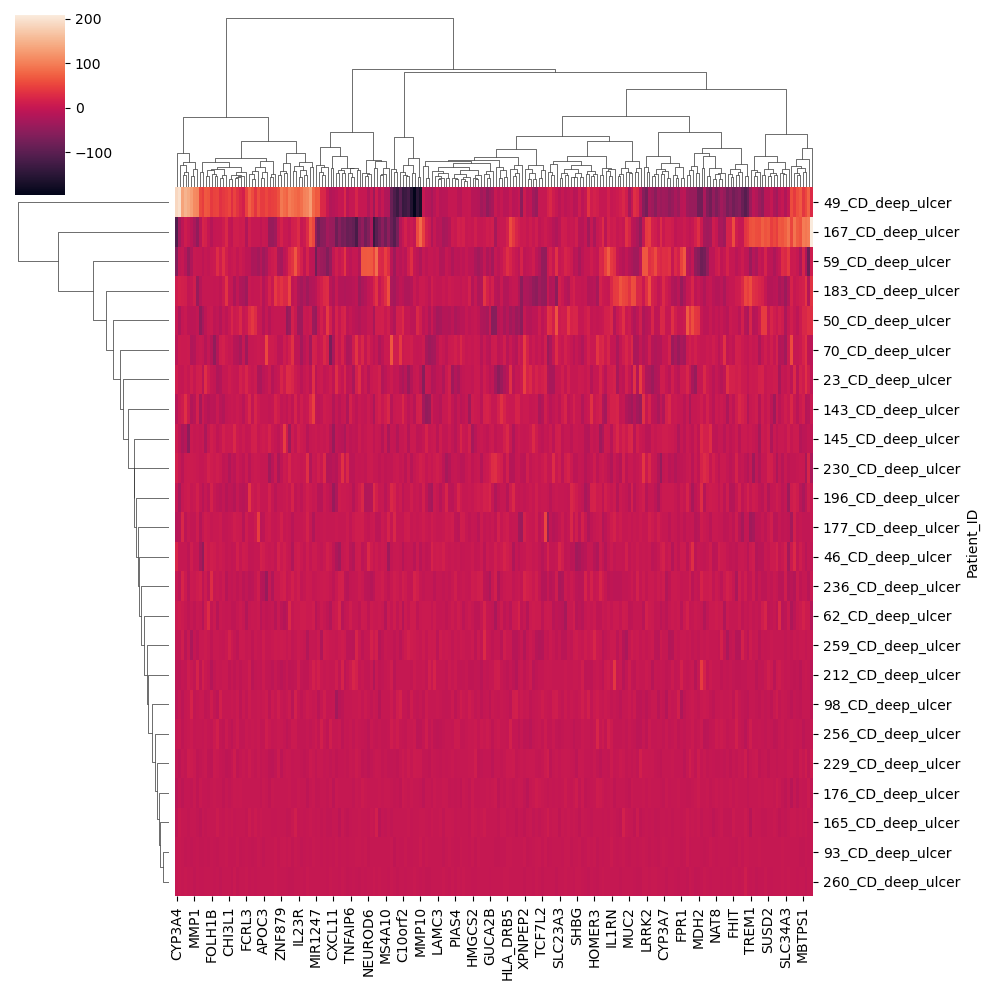

In [122]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [123]:
gene_cluster_cd_deep

array([[ 85.        , 180.        ,  29.42167668,   2.        ],
       [  8.        , 215.        ,  37.99120337,   2.        ],
       [ 29.        , 205.        ,  39.51647248,   2.        ],
       [198.        ,  70.        ,  39.72716579,   2.        ],
       [113.        , 101.        ,  39.78947595,   2.        ],
       [ 21.        , 111.        ,  40.00025529,   2.        ],
       [211.        ,  54.        ,  40.11634703,   2.        ],
       [123.        , 183.        ,  41.35651484,   2.        ],
       [117.        , 167.        ,  42.12109192,   2.        ],
       [ 99.        , 130.        ,  42.43696298,   2.        ],
       [ 42.        , 220.        ,  42.52330649,   3.        ],
       [  9.        , 107.        ,  43.3123843 ,   2.        ],
       [132.        , 116.        ,  44.25083927,   2.        ],
       [ 74.        , 154.        ,  44.85039518,   2.        ],
       [195.        ,  67.        ,  45.77601289,   2.        ],
       [228.        ,  61

In [124]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [125]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([ 20, 210, 109,  10, 105,  57, 102,  16,  38, 121, 191, 157,  64,
         25, 153, 176,  71, 110,   8, 215, 195,  67,  96, 166, 141,  29,
        205, 138,  73, 213,   4,  51, 217,  35,  50,  97, 202, 104,  81,
        127, 163, 142, 148,  48, 114,  86, 209,  68, 119,  52, 188,  47,
        185, 168,  76,  92, 192, 120,  46, 100,  12,  56, 197,  78,  58,
        201, 115, 160, 126,   3,  82, 177, 162, 172,  65,  14,  87, 147,
         26, 178,  89, 118, 204,  75,  60, 199,  24,  90, 117, 167,  61,
         83, 132, 116, 206, 211,  54,  22,  85, 180,  42,  18, 198,  70,
         37,   0, 151,  33,  55, 133, 139, 158, 125,  36, 155, 112, 200,
        164, 190, 152, 113, 101, 123, 183, 103, 129,  91, 137, 145, 181,
          1,  72, 149, 124, 212, 136,   5, 208,  80, 214, 184,  32, 193,
         17, 203, 156, 186, 150, 106,  40, 108, 194, 182,  59,  79,  62,
        218,  53, 174,  39, 140, 144,  41,  45,  94,  34, 196,  49,  15,
         74, 154,   9, 107,  13,  27,   7,  43, 159

In [126]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [127]:
cluster_labels

array([106, 131, 200,  70,  31, 137, 212, 176,  19, 172,   4, 191,  61,
       174,  76, 169,   8, 144, 102, 201,   1, 186,  98, 192,  87,  14,
        79, 175, 182,  26, 198, 190, 142, 108, 166,  34, 114, 105,   9,
       160, 150, 163, 101, 177, 196, 164,  59,  52,  44, 168,  35,  32,
        50, 158,  97, 109,  62,   6,  65, 154,  85,  91, 156, 218,  13,
        75, 208,  22,  48, 194, 104,  17, 132,  29, 170,  84,  55, 215,
        64, 155, 139,  39,  71,  92, 217,  99,  46,  77, 193,  81,  88,
       127,  56, 211, 165, 220,  23,  36, 213, 188,  60, 122,   7, 125,
        38,   5, 149, 173, 151,   3,  18, 187, 116, 121,  45,  67,  94,
        89,  82,  49,  58,  10, 209, 123, 134, 113,  69,  40, 202, 126,
       189, 205,  93, 110, 199, 179, 136, 128,  28, 111, 161,  25,  42,
       185, 162, 129, 210,  78,  43, 133, 148, 107, 120,  15, 171, 115,
       146,  12, 112, 178,  68, 219,  73,  41, 118, 195,  24,  90,  54,
       214, 184, 206,  74, 204, 159, 183,  16,  72,  80, 207, 10

In [128]:
df_cd_deep.columns.get_loc("OSM")

63

In [129]:
np.where(cluster_labels == 2) #osm

(array([210], dtype=int64),)

In [130]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-5.496363,11.652575,-34.890732,-11.931632,-1.562356,2.445564,13.083386,AADAC,106
APOA1,24.0,-0.789341,16.642071,-47.298582,-2.419380,0.000000,4.666901,35.764123,APOA1,131
APOA4,24.0,-0.037038,16.198998,-24.597463,-9.649359,-0.495575,3.916130,57.741192,APOA4,200
APOB,24.0,4.653398,29.010648,-101.019448,0.000000,4.242113,9.345444,85.675325,APOB,70
APOC3,24.0,-1.031784,13.705945,-35.051066,-5.279232,0.050643,2.537448,42.587423,APOC3,31
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,1.764898,8.491458,-7.673958,-3.928331,0.551885,3.311928,30.051868,NXF4,20
RNF125,24.0,3.593158,21.356245,-49.988338,-3.129121,0.000000,7.496647,72.389340,RNF125,203
DARS,24.0,0.088958,16.491311,-42.729326,-4.007470,0.000000,7.237860,42.873870,DARS,33
DNAI1,24.0,1.764544,17.661747,-35.833474,-5.200349,-0.074214,4.381183,58.721092,DNAI1,157


In [131]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-5.496363,106,AADAC
APOA1,-0.789341,131,APOA1
APOA4,-0.037038,200,APOA4
APOB,4.653398,70,APOB
APOC3,-1.031784,31,APOC3
...,...,...,...
NXF4,1.764898,20,NXF4
RNF125,3.593158,203,RNF125
DARS,0.088958,33,DARS
DNAI1,1.764544,157,DNAI1


In [132]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-5.496363,106,AADAC
APOA1,-0.789341,131,APOA1
APOA4,-0.037038,200,APOA4
APOB,4.653398,70,APOB
APOC3,-1.031784,31,APOC3
...,...,...,...
NXF4,1.764898,20,NXF4
RNF125,3.593158,203,RNF125
DARS,0.088958,33,DARS
DNAI1,1.764544,157,DNAI1


In [133]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [134]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [135]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [136]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,6.250687,1,[FCGR3A]
2,7.510481,1,[HDLBP]
3,2.599572,1,[ALDH1A2]
4,4.454185,1,[CNR1]
5,3.666903,1,[SOAT2]
...,...,...,...
216,8.503077,1,[MBTPS1]
217,7.729605,1,[SLC11A1]
218,5.896046,1,[OSM]


In [137]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,6.250687,1,[FCGR3A],FCGR3A
2,7.510481,1,[HDLBP],HDLBP
3,2.599572,1,[ALDH1A2],ALDH1A2
4,4.454185,1,[CNR1],CNR1
5,3.666903,1,[SOAT2],SOAT2
...,...,...,...,...
216,8.503077,1,[MBTPS1],MBTPS1
217,7.729605,1,[SLC11A1],SLC11A1
218,5.896046,1,[OSM],OSM


In [138]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [139]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
8,6.250687,1,[FCGR3A],FCGR3A
4,7.510481,1,[HDLBP],HDLBP
1,2.599572,1,[ALDH1A2],ALDH1A2
2,4.454185,1,[CNR1],CNR1
3,3.666903,1,[SOAT2],SOAT2
...,...,...,...,...
214,8.503077,1,[MBTPS1],MBTPS1
216,7.729605,1,[SLC11A1],SLC11A1
217,5.896046,1,[OSM],OSM
219,4.843183,1,[HCAR2],HCAR2


In [140]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,2.599572,1,[ALDH1A2],ALDH1A2
2,4.454185,1,[CNR1],CNR1
3,3.666903,1,[SOAT2],SOAT2
4,7.510481,1,[HDLBP],HDLBP
5,2.450289,1,[MMP1],MMP1
...,...,...,...,...
216,7.729605,1,[SLC11A1],SLC11A1
217,5.896046,1,[OSM],OSM
218,4.000435,1,[TNFAIP2],TNFAIP2
219,4.843183,1,[HCAR2],HCAR2


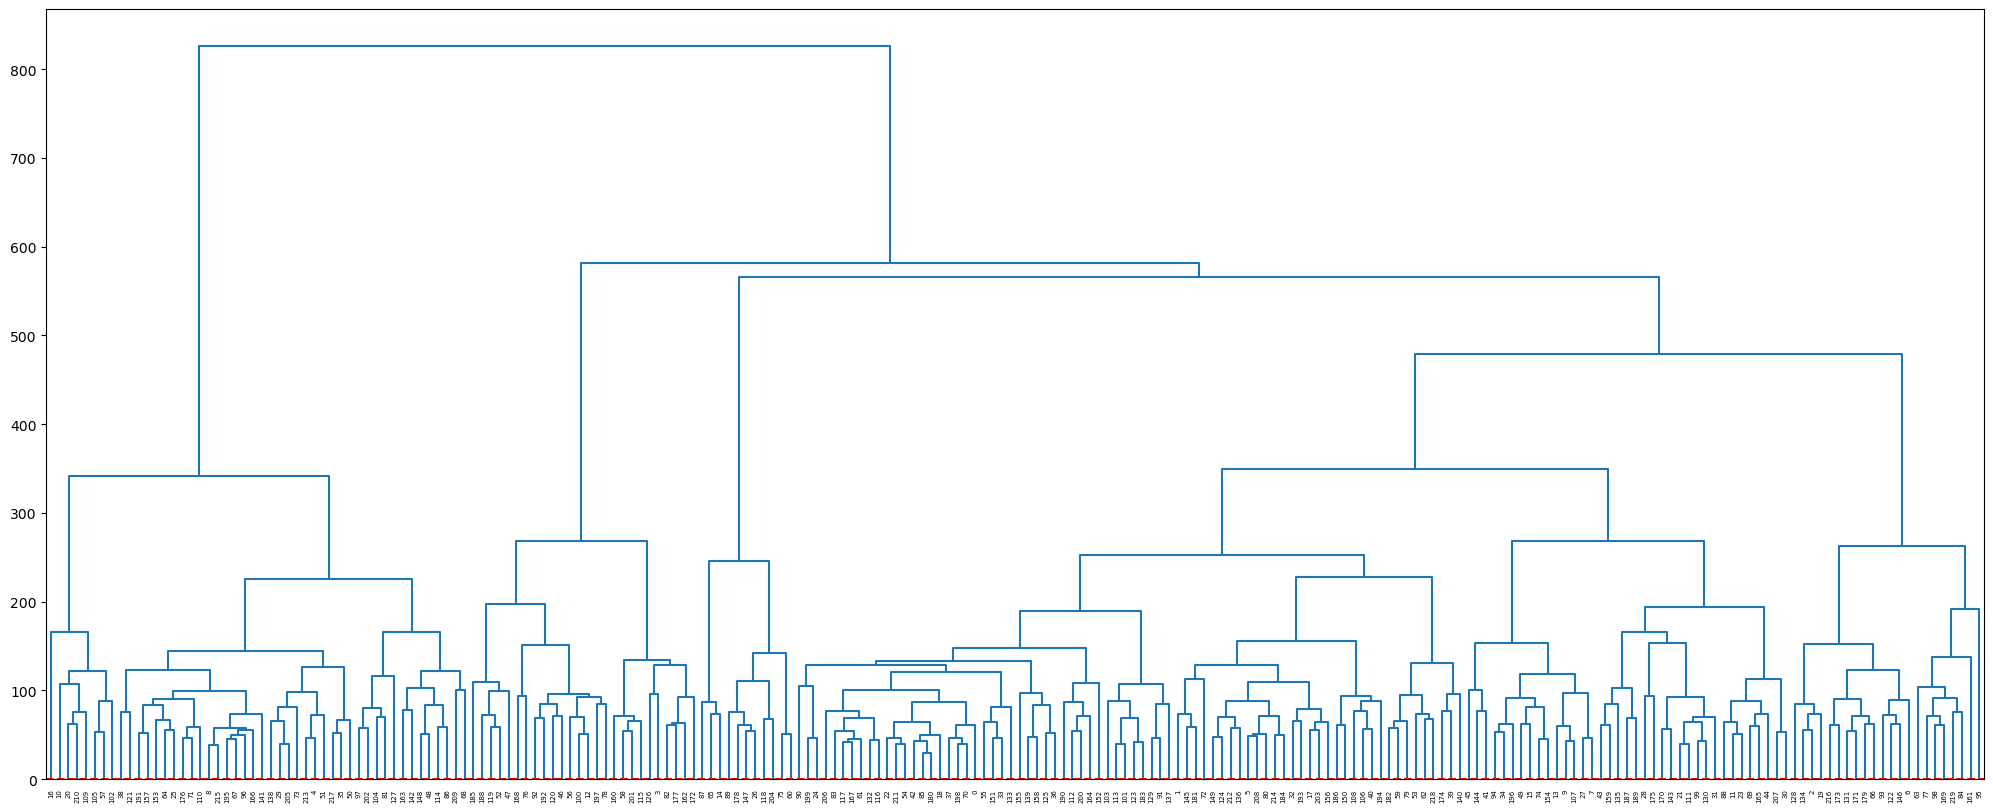

In [141]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

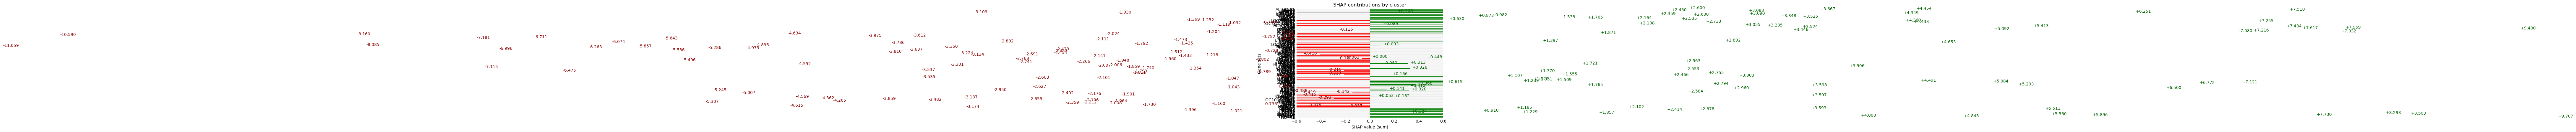

In [142]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [74]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [97]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

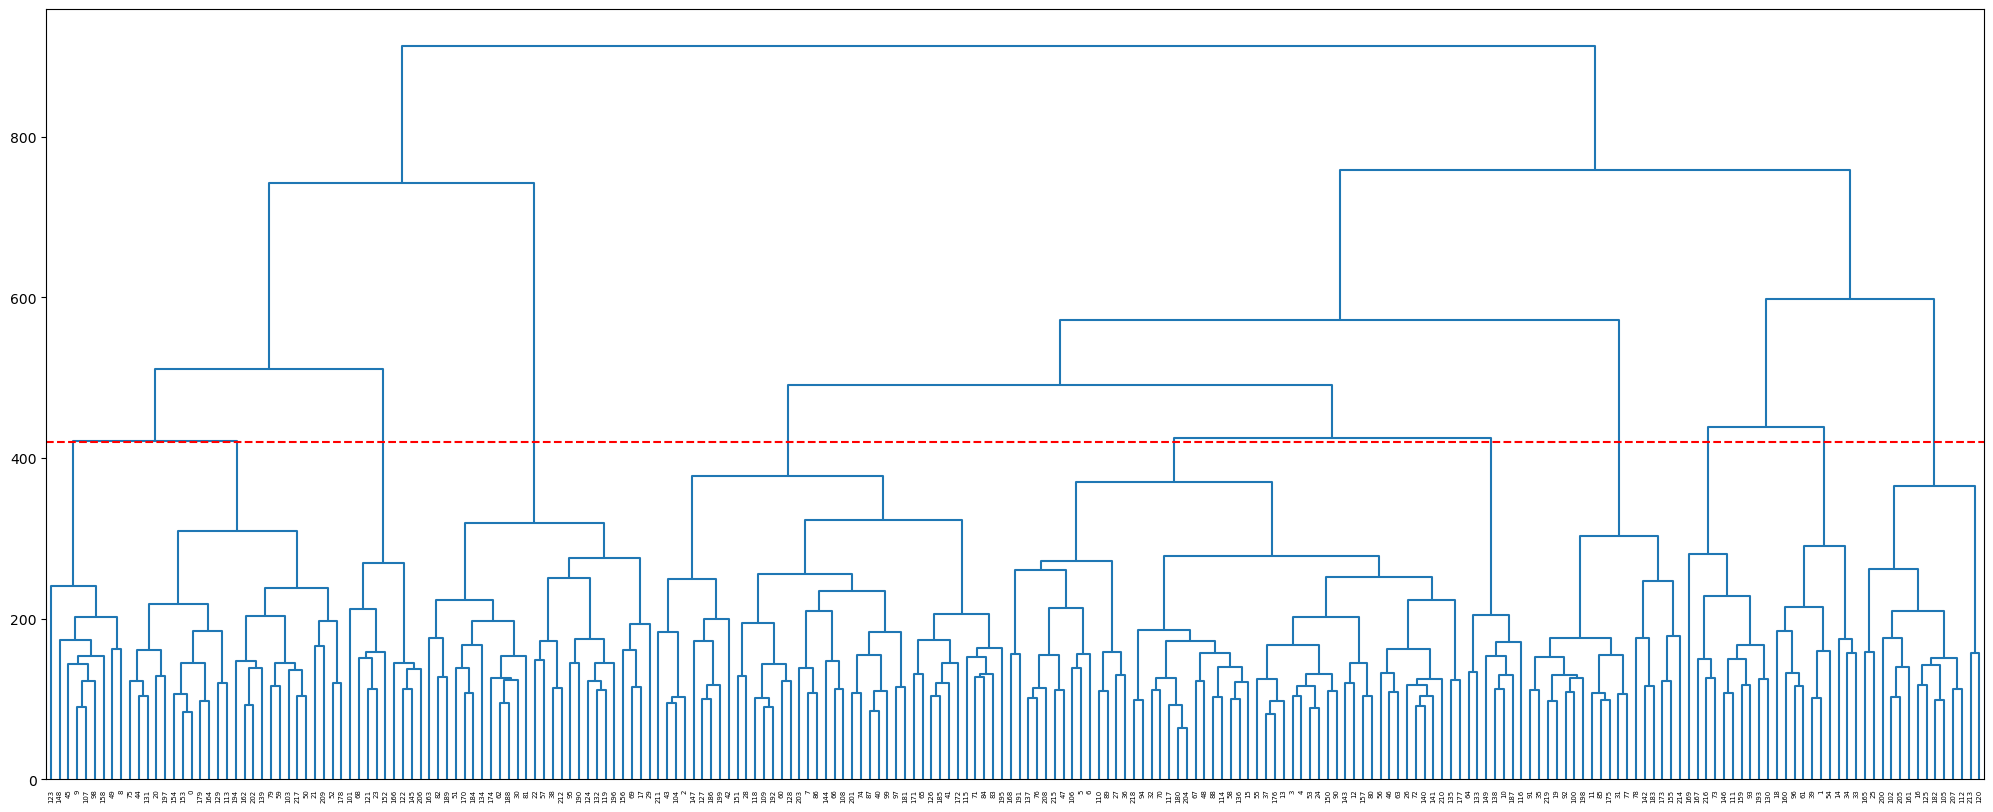

In [98]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = thresh)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [99]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([123, 148,  45,   9, 107,  98, 158,  49,   8,  75,  44, 131,  20,
       197, 154, 153,   0, 179, 164, 129, 113, 194, 162, 202, 139,  79,
        59, 103, 217,  50,  21, 209,  52, 178, 101,  68, 121,  23, 152,
       166, 122, 145, 206, 163,  82, 189,  51, 170, 184, 134, 174,  62,
       188,  30,  81,  22,  57,  38, 212,  95, 190, 124, 132, 119, 196,
       156,  69,  17,  29, 211,  43, 104,   2, 147, 127, 186, 199,  42,
       151,  28, 118, 109, 192,  60, 128, 203,   7,  86, 144,  66, 108,
       201,  74,  87,  40,  99,  97, 181, 171,  65, 126, 185,  41, 172,
       115,  71,  84,  83, 195, 168, 191, 137,  76, 208, 215,  47, 106,
         5,   6, 110,  89,  27,  36, 218,  94,  32,  70, 117, 180, 204,
        67,  48,  88, 114,  58, 136,  15,  55,  37, 176,  13,   3,   4,
        53,  24, 150,  90, 143,  12, 157,  80,  56,  46,  63,  26,  72,
       140, 141, 210, 135, 177,  64, 133, 149, 138,  10, 187, 116,  91,
        35, 219,  19,  92, 100, 198,  11,  85, 175,  31,  77,  7

In [100]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

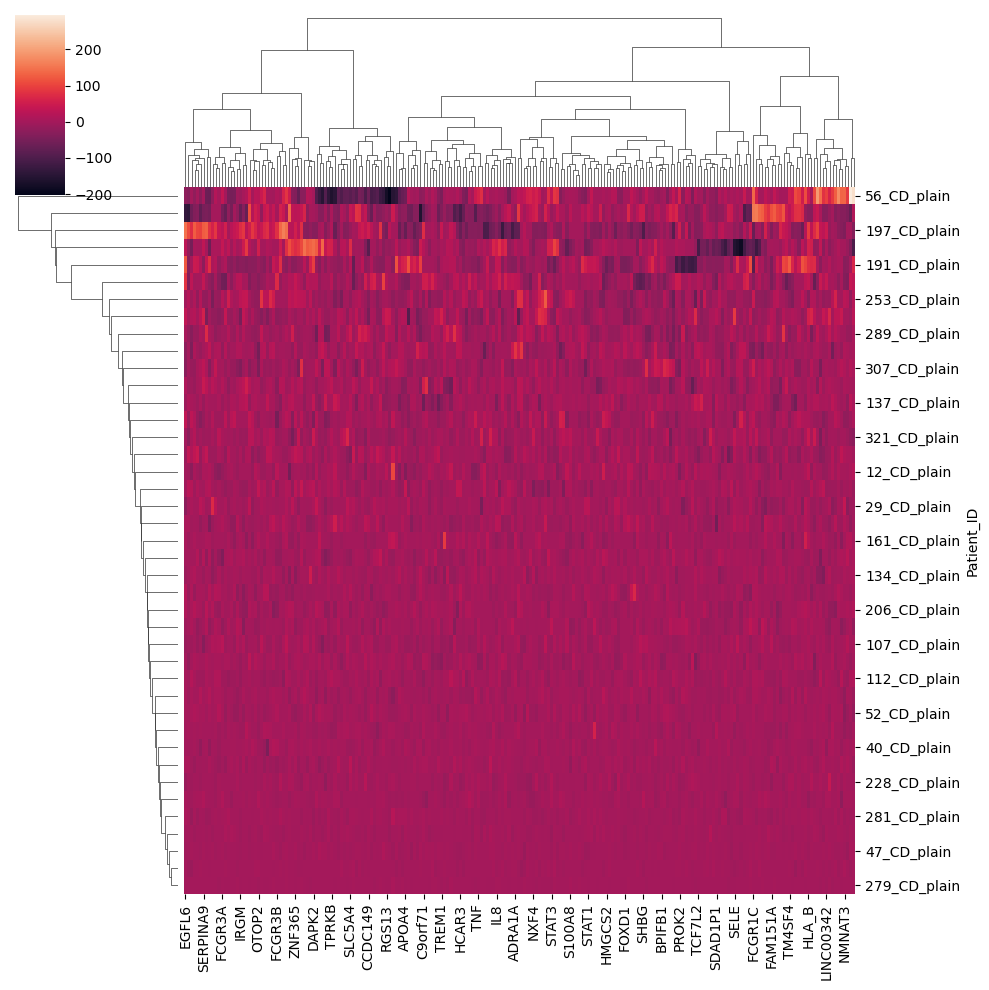

In [101]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [102]:
gene_cluster_cd_plain

array([[180.        , 204.        ,  64.10327782,   2.        ],
       [ 37.        , 176.        ,  81.73606113,   2.        ],
       [153.        ,   0.        ,  83.81835942,   2.        ],
       [ 87.        ,  40.        ,  84.56717092,   2.        ],
       [ 53.        ,  24.        ,  88.08100447,   2.        ],
       [  9.        , 107.        ,  89.96766851,   2.        ],
       [109.        , 192.        ,  90.03047193,   2.        ],
       [ 72.        , 140.        ,  91.05466494,   2.        ],
       [162.        , 202.        ,  92.44909276,   2.        ],
       [117.        , 220.        ,  92.5726162 ,   3.        ],
       [ 62.        , 188.        ,  94.92764843,   2.        ],
       [ 43.        , 104.        ,  95.0330922 ,   2.        ],
       [221.        ,  13.        ,  97.37470783,   3.        ],
       [219.        ,  19.        ,  97.38578927,   2.        ],
       [179.        , 164.        ,  97.83824943,   2.        ],
       [182.        , 105

In [103]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [104]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([  9, 107,  98,  45, 158, 148,  49,   8, 123,  44, 131,  75,  20,
        197, 153,   0, 154, 179, 164, 129, 113, 162, 202, 139, 194,  79,
         59, 217,  50, 103,  21, 209,  52, 178, 121,  23,  68, 152, 101,
        122, 145, 206, 166,  82, 189, 163, 170, 184,  51, 134,  62, 188,
         30, 174,  81,  22,  57,  38, 212,  95, 190, 132, 119, 124, 196,
         69,  17, 156,  29,  43, 104,   2, 211, 127, 186, 199, 147,  42,
        151,  28, 109, 192, 118,  60, 128,   7,  86, 203,  66, 108, 144,
        201,  74,  87,  40,  99,  97, 181, 171,  65, 126, 185,  41, 172,
         71,  84,  83, 115, 195, 168, 191, 137,  76, 208, 215,  47, 106,
          5,   6, 110,  89,  27,  36, 218,  94,  32,  70, 180, 204, 117,
         67,  48,  88, 114,  58, 136,  15,  37, 176,  13,  55,   3,   4,
         53,  24, 150,  90, 143,  12, 157,  80,  46,  63,  56,  72, 140,
        141,  26, 210, 135, 177,  64, 133, 138,  10, 187, 149, 116,  91,
         35, 219,  19,  92, 100, 198,  85, 175,  11

In [105]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [106]:
cluster_labels

array([ 16, 202,  72, 142, 143, 118, 119,  86,   8,   1, 165, 178, 149,
       140, 206, 137, 213,  67, 200, 172,  13,  31,  56,  36, 145, 208,
       158, 122,  80,  69,  53, 179, 126, 205, 204, 170, 123, 138,  58,
       201,  95, 103,  78,  70,  10,   4, 152, 116, 132,   7,  29,  49,
        33, 144, 203, 141, 154,  57, 135,  27,  84, 198,  51, 153, 162,
       100,  89, 131,  37,  66, 127, 105, 155, 188,  93,  12, 113, 180,
       183,  26, 151,  55,  44, 107, 106, 176,  87,  94, 133, 121, 147,
       169, 173, 193, 125,  60, 197,  97,   3,  96, 174,  39, 209,  30,
        71, 216, 117,   2,  90,  81, 120, 191, 218,  21, 134, 108, 168,
       130,  83,  63, 220,  35,  40,   9,  64, 214, 101,  74,  85,  20,
       195,  11,  62, 163,  50, 160, 136, 112, 164,  24, 156, 157, 181,
       148,  91,  41, 190,  77,   6, 167, 146,  79,  38,  15,  17, 185,
        68, 150,   5, 192, 199, 211,  22,  46,  19, 207,  43, 189, 110,
       196,  47,  99, 104, 184,  54, 177, 139, 161,  34,  18, 12

In [107]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-1.724248,14.071889,-50.218191,-7.424110,0.000000,3.023809,37.070282,AADAC,16
APOA1,41.0,4.335773,24.193076,-34.966118,-2.863813,0.000000,5.301969,94.079394,APOA1,202
APOA4,41.0,-3.278246,22.355494,-70.818642,-7.542755,0.000000,5.276835,65.060500,APOA4,72
APOB,41.0,-1.561588,14.730947,-61.732108,-9.153109,0.000000,6.332228,24.395590,APOB,142
APOC3,41.0,-0.080706,12.561380,-25.871006,-8.550882,0.215587,4.843541,36.407864,APOC3,143
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,0.046268,18.270768,-43.602476,-6.324566,0.000000,6.940221,47.558527,NXF4,115
RNF125,41.0,-0.644708,28.713830,-93.595405,-9.093062,0.085230,5.500666,134.284258,RNF125,187
DARS,41.0,3.878412,15.553978,-27.546057,-0.536994,1.632986,7.311946,70.796314,DARS,28
DNAI1,41.0,-0.075698,17.157173,-58.874741,-1.962579,0.624274,6.136165,56.200759,DNAI1,124


In [108]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-1.724248,16,AADAC
APOA1,4.335773,202,APOA1
APOA4,-3.278246,72,APOA4
APOB,-1.561588,142,APOB
APOC3,-0.080706,143,APOC3
...,...,...,...
NXF4,0.046268,115,NXF4
RNF125,-0.644708,187,RNF125
DARS,3.878412,28,DARS
DNAI1,-0.075698,124,DNAI1


In [109]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-1.724248,16,AADAC
APOA1,4.335773,202,APOA1
APOA4,-3.278246,72,APOA4
APOB,-1.561588,142,APOB
APOC3,-0.080706,143,APOC3
...,...,...,...
NXF4,0.046268,115,NXF4
RNF125,-0.644708,187,RNF125
DARS,3.878412,28,DARS
DNAI1,-0.075698,124,DNAI1


In [110]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,5.676973,1,[ABCC2]
2,2.193816,1,[FCN3]
3,-0.055498,1,[TNFAIP2]
4,-0.572092,1,[IL10RA]
5,4.646991,1,[SERPINA9]
...,...,...,...
216,2.139684,1,[SOAT2]
217,1.239792,1,[NMNAT3]
218,-1.030891,1,[CLDN8]


In [111]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,5.676973,1,[ABCC2],ABCC2
2,2.193816,1,[FCN3],FCN3
3,-0.055498,1,[TNFAIP2],TNFAIP2
4,-0.572092,1,[IL10RA],IL10RA
5,4.646991,1,[SERPINA9],SERPINA9
...,...,...,...,...
216,2.139684,1,[SOAT2],SOAT2
217,1.239792,1,[NMNAT3],NMNAT3
218,-1.030891,1,[CLDN8],CLDN8


In [112]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [113]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
9,5.676973,1,[ABCC2],ABCC2
6,2.193816,1,[FCN3],FCN3
4,-0.055498,1,[TNFAIP2],TNFAIP2
1,-0.572092,1,[IL10RA],IL10RA
2,4.646991,1,[SERPINA9],SERPINA9
...,...,...,...,...
216,2.139684,1,[SOAT2],SOAT2
217,1.239792,1,[NMNAT3],NMNAT3
218,-1.030891,1,[CLDN8],CLDN8
219,5.203140,1,[LOC100507531],LOC100507531


In [114]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.572092,1,[IL10RA],IL10RA
2,4.646991,1,[SERPINA9],SERPINA9
3,-4.445349,1,[IL23R],IL23R
4,-0.055498,1,[TNFAIP2],TNFAIP2
5,4.454657,1,[JAK2],JAK2
...,...,...,...,...
216,2.139684,1,[SOAT2],SOAT2
217,1.239792,1,[NMNAT3],NMNAT3
218,-1.030891,1,[CLDN8],CLDN8
219,5.203140,1,[LOC100507531],LOC100507531


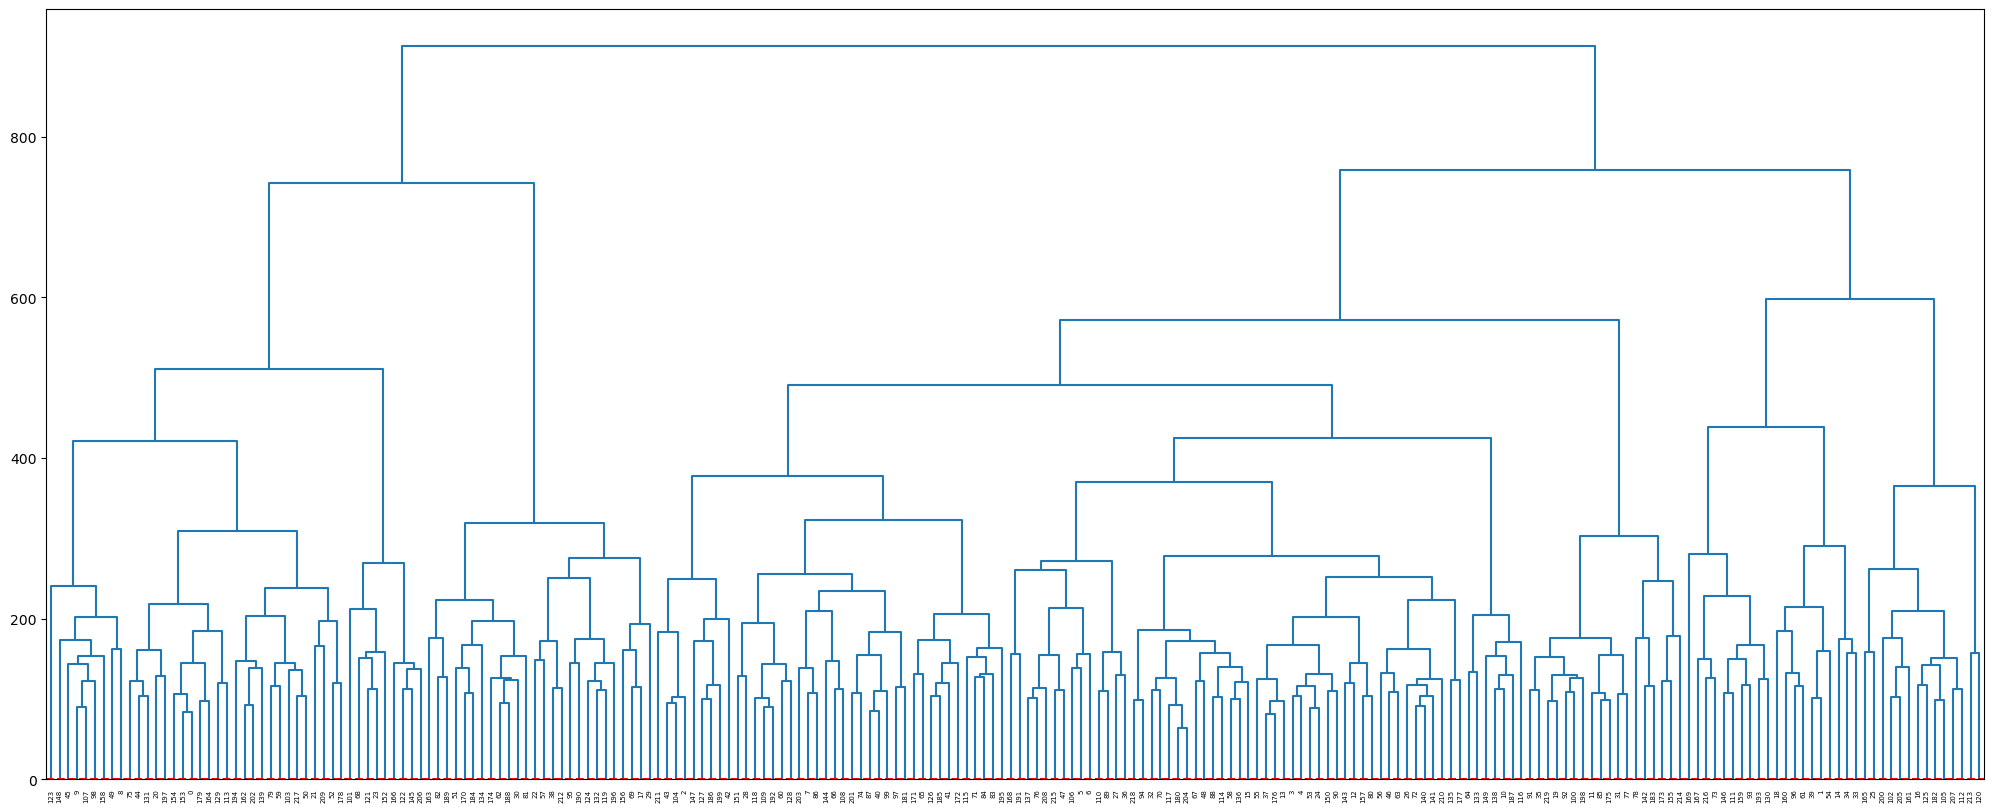

In [115]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

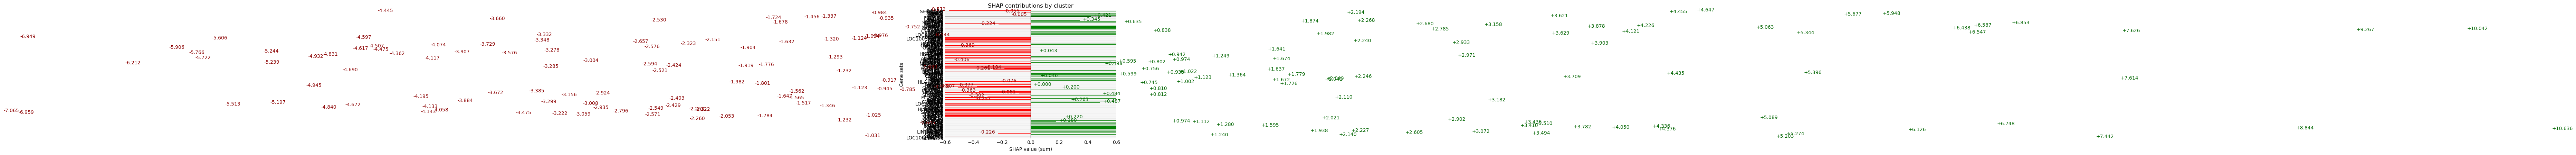

In [116]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [117]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")